In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
from robot_tools import *
import math
import cv2

In [2]:
t = symbols('t')
theta1 = Function(r"\theta_1")(t)
theta1_dot = diff(theta1, t)
theta1_ddot = diff(theta1, t, t)

theta2 = Function(r"\theta_2")(t)
theta2_dot = diff(theta2, t)
theta2_ddot = diff(theta2, t, t)

d3 = Function(r"d_3")(t)
d3_dot = diff(d3, t)
d3_ddot = diff(d3, t, t)

L1 = symbols('L1')
L2 = symbols('L2')

alias = {}

# display as theta dot instead of d(theta)/dt, and ignore dependency (t)
alias.update({theta1: symbols(r"\theta_1"),
              theta1_dot: symbols(r"\dot{\theta_1}"),
              theta1_ddot: symbols(r"\ddot{\theta_1}"),
              theta2: symbols(r"\theta_2"),
              theta2_dot: symbols(r"\dot{\theta_2}"),
              theta2_ddot: symbols(r"\ddot{\theta_2}"),
              d3: symbols(r"d_3"),
              d3_dot: symbols(r"\dot{d_3}"),
              d3_ddot: symbols(r"\ddot{d_3}")
             })

## Qn 1

In [3]:
# a

DH1 = [0, 0, L1, theta1]
T01 = Tlink(DH1)
symprint('T', 0, 1)
matprint(T01, alias)

DH2 = [0, -pi/2, L2, theta2]
T12 = Tlink(DH2)
symprint('T', 1, 2)
matprint(T12, alias)

DH3 = [0, -pi/2, d3, 0]
T23 = Tlink(DH3)
symprint('T', 2, 3)
matprint(T23, alias)

T03 = simplify(T01 * T12 * T23)
symprint('T', 0, 3)
matprint(T03, alias)

^0T_1

Matrix([
[cos(\theta_1), -sin(\theta_1), 0,  0],
[sin(\theta_1),  cos(\theta_1), 0,  0],
[            0,              0, 1, L1],
[            0,              0, 0,  1]])

^1T_2

Matrix([
[ cos(\theta_2), -sin(\theta_2), 0,  0],
[             0,              0, 1, L2],
[-sin(\theta_2), -cos(\theta_2), 0,  0],
[             0,              0, 0,  1]])

^2T_3

Matrix([
[1,  0, 0,   0],
[0,  0, 1, d_3],
[0, -1, 0,   0],
[0,  0, 0,   1]])

^0T_3

Matrix([
[cos(\theta_1)*cos(\theta_2),  sin(\theta_1), -sin(\theta_2)*cos(\theta_1), -L2*sin(\theta_1) - d_3*sin(\theta_2)*cos(\theta_1)],
[sin(\theta_1)*cos(\theta_2), -cos(\theta_1), -sin(\theta_1)*sin(\theta_2),  L2*cos(\theta_1) - d_3*sin(\theta_1)*sin(\theta_2)],
[             -sin(\theta_2),              0,               -cos(\theta_2),                              L1 - d_3*cos(\theta_2)],
[                          0,              0,                            0,                                                   1]])

In [4]:
# c

omega = Matrix([0, 0, 0])
v = Matrix([0, 0, 0])


omega_11, v_11 = revolute_joint(frame = 1, 
                                theta_dot = theta1_dot, 
                                transform_low_high = T01, 
                                omega = omega, v = v, 
                                alias = alias)

omega_22, v_22 = revolute_joint(frame = 2, 
                                theta_dot = theta2_dot, 
                                transform_low_high = T12, 
                                omega = omega_11, v = v_11, 
                                alias = alias)

omega_33, v_33 = prismatic_joint(frame = 3, 
                                d_dot = d3_dot, 
                                transform_low_high = T23, 
                                omega = omega_22, v = v_22, 
                                alias = alias)

Jee, J0 = Jacobian(parameters = [theta1_dot, theta2_dot, d3_dot], 
                   v_ee = v_33, 
                   omega_ee = omega_33, 
                   transform_low_high = T03,
                   alias = alias)

^1\Omega_1

Matrix([
[             0],
[             0],
[\dot{\theta_1}]])

^1V_1

Matrix([
[0],
[0],
[0]])

^2\Omega_2

Matrix([
[-\dot{\theta_1}*sin(\theta_2)],
[-\dot{\theta_1}*cos(\theta_2)],
[               \dot{\theta_2}]])

^2V_2

Matrix([
[-L2*\dot{\theta_1}*cos(\theta_2)],
[ L2*\dot{\theta_1}*sin(\theta_2)],
[                               0]])

^3\Omega_3

Matrix([
[-\dot{\theta_1}*sin(\theta_2)],
[              -\dot{\theta_2}],
[-\dot{\theta_1}*cos(\theta_2)]])

^3V_3

Matrix([
[-L2*\dot{\theta_1}*cos(\theta_2) - \dot{\theta_2}*d_3],
[                     \dot{\theta_1}*d_3*sin(\theta_2)],
[          L2*\dot{\theta_1}*sin(\theta_2) + \dot{d_3}]])

^eJ_e

Matrix([
[-L2*cos(\theta_2), -d_3, 0],
[d_3*sin(\theta_2),    0, 0],
[ L2*sin(\theta_2),    0, 1],
[   -sin(\theta_2),    0, 0],
[                0,   -1, 0],
[   -cos(\theta_2),    0, 0]])

^0J_

Matrix([
[-L2*cos(\theta_1) + d_3*sin(\theta_1)*sin(\theta_2), -d_3*cos(\theta_1)*cos(\theta_2), -sin(\theta_2)*cos(\theta_1)],
[-L2*sin(\theta_1) - d_3*sin(\theta_2)*cos(\theta_1), -d_3*sin(\theta_1)*cos(\theta_2), -sin(\theta_1)*sin(\theta_2)],
[                                                  0,                d_3*sin(\theta_2),               -cos(\theta_2)],
[                                                  0,                   -sin(\theta_1),                            0],
[                                                  0,                    cos(\theta_1),                            0],
[                                                  1,                                0,                            0]])

In [5]:
# d
J0 = J0.subs({theta1: pi/2, theta2: pi/2, d3: 1, 
        theta1_dot: 1, theta2_dot: 0, d3_dot: 1})
J0

Matrix([
[  1,  0,  0],
[-L2,  0, -1],
[  0,  1,  0],
[  0, -1,  0],
[  0,  0,  0],
[  1,  0,  0]])

In [6]:
J0 * Matrix([1, 0, 1])

Matrix([
[      1],
[-L2 - 1],
[      0],
[      0],
[      0],
[      1]])

In [12]:
# e
# Q5

def angular_acce(frame, joint_type, transform_low_high, omega_prev, omega_dot_prev, theta_dot, theta_ddot, alias, Display = True):
    
    '''
    See Chapter 5 Equation 32 and 33 for details
    Note on the indices:
    omega_prev: i
    omega_dot_prev: i
    theta_dot: i+1
    theta_ddot: i+1
    output: i+1
    '''
    
    # Transpose and extract the 3x3 matrix
    rotation_high_low = transform_low_high.T[:3, :3]
    
    if joint_type == 'r':
        # Equation 32
        omega_new = simplify(rotation_high_low * omega_dot_prev +
                             rotation_high_low * omega_prev.cross(theta_dot * Matrix([0, 0, 1])) +
                             theta_ddot * Matrix([0, 0, 1])
                            )
        if Display == True:
            if type(frame) == int:
                symprint('\dot{\\Omega}', frame, frame)
            else:
                symprint('\dot{\\Omega}', '', frame)  
            matprint(omega_new, alias)
            
    elif joint_type == 'p':
        # Equation 33
        omega_new = simplify(rotation_high_low * omega_dot_prev)
        
        if Display == True:
            symprint('\dot{\\Omega}', frame, frame)
            matprint(omega_new, alias)
            
    else:
        print('Joint type not found, try r and p')
        return None
    
    
    return omega_new


def linear_acce(frame, joint_type, transform_low_high, omega_prev, omega_dot_prev, v_dot_prev, alias, Display = True):
    
    '''
    See Chapter 5 Equation 34 and 35 for details
    Note on the indices:
    omega_prev: i
    omega_dot_prev: i
    v_dot_prev: i
    output: i+1
    '''
    
    
    # Transpose and extract the 3x3 matrix
    rotation_high_low = transform_low_high.T[:3, :3]
    P = transform_low_high[:3, -1]
    
    if joint_type == 'r':
        
        # Equation 34
        v_new = simplify(rotation_high_low * (v_dot_prev + omega_dot_prev.cross(P) + omega_prev.cross(omega_prev.cross(P))))
        
        if Display == True:
            if type(frame) == int:
                symprint('\dot{V}', frame, frame)
            else:
                symprint('\dot{V}', '', frame)
            matprint(v_new, alias)
    elif joint_type == 'p':
        
        # Equation 35 (did not implement)
        pass
        
    else:
        print('Joint type not found, try r and p')
        return None
    
    return v_new

def force_cal(mass, v_dot):
    F = simplify(mass * v_dot)  
    return F
    
def moment_cal(I, omega_dot, omega):
    
    intermediate = I * omega
    M = simplify(I * omega_dot + omega.cross(intermediate))
    return M

    
    

In [15]:
# Outward iteration to find the Force and moment on the COM
omega_00 = Matrix([0, 0, 0])
omega_dot_00 = Matrix([0, 0, 0])
v_00 = Matrix([0, 0, 0])
g = symbols('g')
v_dot_00 = Matrix([0, 0, 0])


omega_dot_11 = angular_acce(frame = 1,
                 joint_type = 'r',
                 transform_low_high = T01,
                 omega_prev = omega_00,
                 omega_dot_prev = omega_dot_00,
                 theta_dot = theta1_dot,
                 theta_ddot = theta1_ddot,
                 alias = alias)

v_dot_11 = linear_acce(frame = 1,
                 joint_type = 'r',
                 transform_low_high = T01,
                 omega_prev = omega_00,
                 omega_dot_prev = omega_dot_00,
                 v_dot_prev = v_dot_00,
                 alias = alias)

omega_dot_22 = angular_acce(frame = 2,
                 joint_type = 'r',
                 transform_low_high = T12,
                 omega_prev = omega_11,
                 omega_dot_prev = omega_dot_11,
                 theta_dot = theta2_dot,
                 theta_ddot = theta2_ddot,
                 alias = alias)

v_dot_22 = linear_acce(frame = 2,
                 joint_type = 'r',
                 transform_low_high = T12,
                 omega_prev = omega_11,
                 omega_dot_prev = omega_dot_11,
                 v_dot_prev = v_dot_11,
                 alias = alias)





^1\dot{\Omega}_1

Matrix([
[              0],
[              0],
[\ddot{\theta_1}]])

^1\dot{V}_1

Matrix([
[0],
[0],
[0]])

^2\dot{\Omega}_2

Matrix([
[-\ddot{\theta_1}*sin(\theta_2)],
[-\ddot{\theta_1}*cos(\theta_2)],
[               \ddot{\theta_2}]])

^2\dot{V}_2

Matrix([
[-L2*\ddot{\theta_1}*cos(\theta_2)],
[ L2*\ddot{\theta_1}*sin(\theta_2)],
[            -L2*\dot{\theta_1}**2]])

In [20]:
# f
l1 = 2
l2 = 1

t2_ini = np.arctan2(-0, 1)
t2_f = np.arctan2(0, -1)

t1_ini = np.arctan2(0, 1)
t1_f = np.arctan2(0, 1)

d3_ini = (l1 - 2)/1
d3_f = (l1 - 3)/-1


In [23]:
print(angle_lst)

[[0.0, 0.0], [0.0, 3.141592653589793], [0.0, 1.0]]


Displacement equations for theta_1


0

Velocity equations for theta_1


0

Acceleration equations for theta_1


0

---------------------------------
Displacement equations for theta_2


-0.785398163397448*t**3 + 2.35619449019234*t**2

Velocity equations for theta_2


-2.35619449019234*t**2 + 4.71238898038469*t

Acceleration equations for theta_2


4.71238898038469 - 4.71238898038469*t

---------------------------------
Displacement equations for theta_3


-0.25*t**3 + 0.75*t**2

Velocity equations for theta_3


-0.75*t**2 + 1.5*t

Acceleration equations for theta_3


1.5 - 1.5*t

---------------------------------


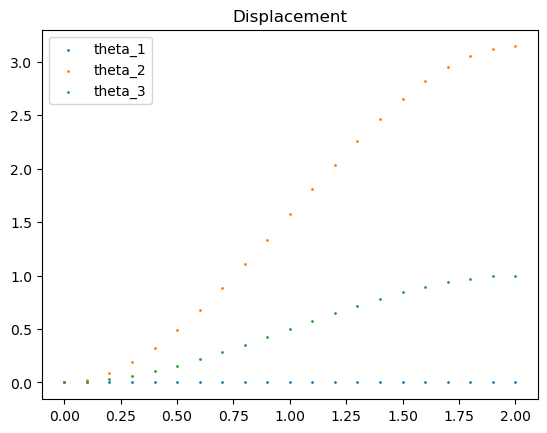

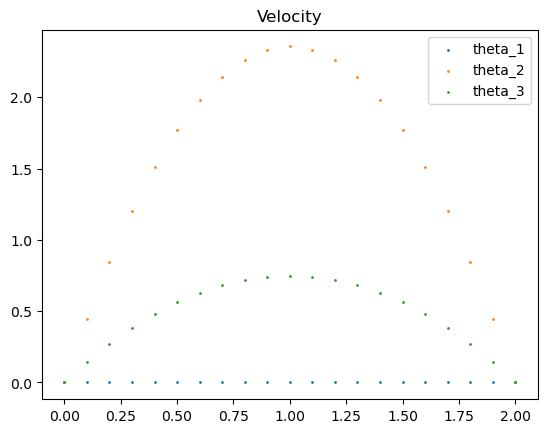

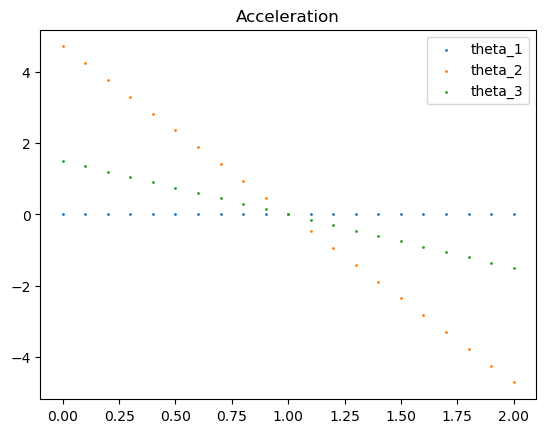

In [25]:
# f

# More comprehensive version

# Initial and final condition
t1 = [t1_ini, t1_f]
t2 = [t2_ini, t2_f]
t3 = [d3_ini, d3_f]
angle_lst = [t1, t2, t3]

# Total motion time
tf = 2
t_lst = np.arange(0, tf + 0.1, 0.1)

# Record for all joints
disp_all = []
vel_all = []
acc_all = []

for i in range(len(angle_lst)):
    
    a0 = angle_lst[i][0]
    a1 = 0
    a2 = 3/tf**2 * (angle_lst[i][-1] - angle_lst[i][0])
    a3 = -2/tf**3 * (angle_lst[i][-1] - angle_lst[i][0])
    
    t = symbols('t')
    print(f'Displacement equations for theta_{i+1}')
    eqn_disp = a0 + a1 * t + a2 * t**2 + a3 * t**3
    
    display(eqn_disp)
    
    disp = [eqn_disp.subs(t, i) for i in t_lst]
    
    disp_list = [float(i) for i in disp]
    
    
    print(f'Velocity equations for theta_{i+1}')
    eqn_vel = a1 + 2 * a2 * t + 3 * a3 * t**2
    
    vel = [eqn_vel.subs(t, i) for i in t_lst]
    display(eqn_vel)
    
    vel_list = [float(i) for i in vel]
    
    print(f'Acceleration equations for theta_{i+1}')
    eqn_acc = 2 * a2 + 6 * a3 * t
    
    acc = [eqn_acc.subs(t, i) for i in t_lst]
    display(eqn_acc)
    
    acc_list = [float(i) for i in acc]
    
    print('---------------------------------')
    disp_all.append(disp_list)
    vel_all.append(vel_list)
    acc_all.append(acc_list)
    
    
for i in range(len(disp_all)):
    plt.scatter(t_lst, disp_all[i], label = f'theta_{i+1}', s=1)
    plt.title('Displacement')
plt.legend()
plt.show()

for i in range(len(disp_all)):
    plt.scatter(t_lst, vel_all[i], label = f'theta_{i+1}', s=1)
    plt.title('Velocity')
plt.legend()
plt.show()

for i in range(len(disp_all)):
    plt.scatter(t_lst, acc_all[i], label = f'theta_{i+1}', s=1)
    plt.title('Acceleration')
plt.legend()
plt.show()
    
    
    

## Qn 4

In [ ]:
def Rotation_non_pincipal_axes(angle, direction, rad = True):
    if rad == False:
        a = math.radians(angle)
    else:
        a = angle
    
    # Convert the direction to unit vector, if the direction is already unit vector, norm = 1
    [ux, uy, uz] = direction/np.linalg.norm(direction)
    
    # Use equation 33
    row1 = np.array([ux*ux*(1-c(a))+c(a), ux*uy*(1-c(a))-uz*s(a), ux*uz*(1-c(a))+uy*s(a)]).reshape(1, -1)
    row2 = np.array([ux*uy*(1-c(a))+uz*s(a), uy*uy*(1-c(a))+c(a), uy*uz*(1-c(a))-ux*s(a)]).reshape(1, -1)
    row3 = np.array([ux*uz*(1-c(a))-uy*s(a), uy*uz*(1-c(a))+ux*s(a), uz*uz*(1-c(a))+c(a)]).reshape(1, -1)
    result = np.concatenate([row1, row2, row3], axis = 0)
    
    return result

In [44]:
ux = symbols('u_x')
uy = symbols('u_y')
uz = symbols('u_z')

a = symbols('\\alpha')
b = symbols('\\beta') 

b = pi/4

ux = 0
uy = -cos(b)
uz = sin(b)


row1 = Matrix([ux*ux*(1-cos(a))+cos(a), 
               ux*uy*(1-cos(a))-uz*sin(a), 
               ux*uz*(1-cos(a))+uy*sin(a)]).T

row2 = Matrix([ux*uy*(1-cos(a))+uz*sin(a), 
               uy*uy*(1-cos(a))+cos(a), 
               uy*uz*(1-cos(a))-ux*sin(a)]).T

row3 = Matrix([ux*uz*(1-cos(a))-uy*sin(a), 
               uy*uz*(1-cos(a))+ux*sin(a), 
               uz*uz*(1-cos(a))+cos(a)]).T

full_mat = simplify(Matrix([row1, row2, row3]))

T2 = full_mat.col_insert(3, Matrix([0, 0, 0]))
T2 = T2.row_insert(3, Matrix([0, 0, 0, 1]).T)

T2

Matrix([
[          cos(\alpha), -sqrt(2)*sin(\alpha)/2, -sqrt(2)*sin(\alpha)/2, 0],
[sqrt(2)*sin(\alpha)/2,    cos(\alpha)/2 + 1/2,    cos(\alpha)/2 - 1/2, 0],
[sqrt(2)*sin(\alpha)/2,    cos(\alpha)/2 - 1/2,    cos(\alpha)/2 + 1/2, 0],
[                    0,                      0,                      0, 1]])

In [45]:
T1 = Matrix([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 12],
            [0, 0, 0, 1]])
T1

Matrix([
[1, 0, 0,  0],
[0, 1, 0,  0],
[0, 0, 1, 12],
[0, 0, 0,  1]])

In [47]:
T1 * T2

Matrix([
[          cos(\alpha), -sqrt(2)*sin(\alpha)/2, -sqrt(2)*sin(\alpha)/2,  0],
[sqrt(2)*sin(\alpha)/2,    cos(\alpha)/2 + 1/2,    cos(\alpha)/2 - 1/2,  0],
[sqrt(2)*sin(\alpha)/2,    cos(\alpha)/2 - 1/2,    cos(\alpha)/2 + 1/2, 12],
[                    0,                      0,                      0,  1]])

## Qn 2

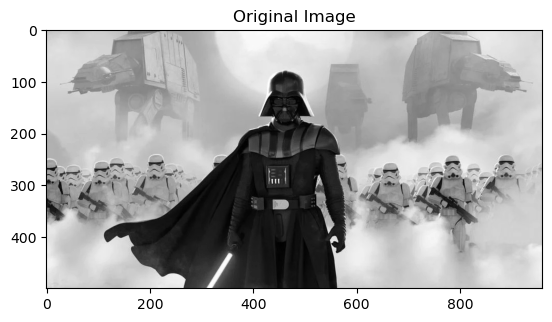

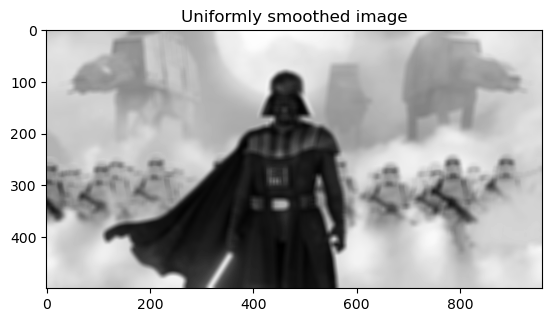

In [50]:
img = cv2.imread('Past Paper Resource/StarWars.jpeg')
# Divide 255 to convert image from range 0-255 to 0-1
imgBw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
plt.imshow(imgBw, cmap=plt.cm.gray)
plt.title('Original Image')
plt.show()

kernal_size = 11

# Uniform kernal of size 21
kernel = np.ones([kernal_size,kernal_size])/kernal_size**2

uniform_smoothed = cv2.filter2D(imgBw, -1, kernel)
plt.imshow(uniform_smoothed, cmap=plt.cm.gray)
plt.title('Uniformly smoothed image')
plt.show()

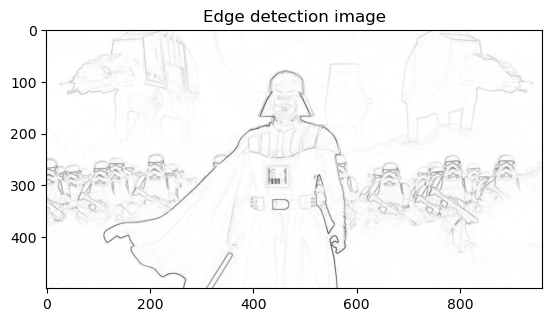

In [51]:
# Image B
K = np.array([0.5, 0, -0.5]).reshape(-1, 1)
edge_hor = cv2.filter2D(imgBw, -1, K)
edge_ver = cv2.filter2D(imgBw, -1, K.T)

edge = 1 - np.sqrt(edge_hor**2 + edge_ver**2)
plt.imshow(edge, cmap=plt.cm.gray)
plt.title('Edge detection image')
plt.show()

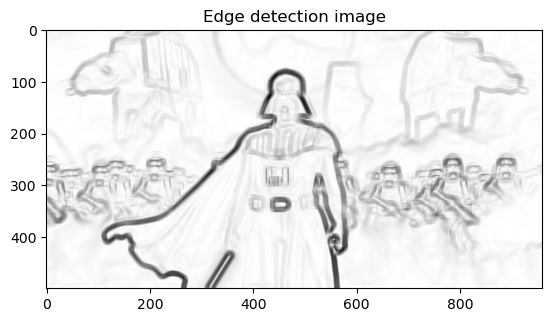

In [52]:
# Image C
K = np.array([0.5, 0, -0.5]).reshape(-1, 1)
edge_hor = cv2.filter2D(uniform_smoothed, -1, K)
edge_ver = cv2.filter2D(uniform_smoothed, -1, K.T)

edge = 1 - np.sqrt(edge_hor**2 + edge_ver**2)
plt.imshow(edge, cmap=plt.cm.gray)
plt.title('Edge detection image')
plt.show()